# Integrated Project 2 <a id='intro'></a>

## Task statement

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.

The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.

The model will help to optimize the production and eliminate unprofitable parameters.

## Technological Process

Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.

![Alt Text](process_stages.png)

1. **Flotation**

    Gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals). 
    
    The stability of this process is affected by the volatile and non-optimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).

2. **Purification**

    The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

## Data description
**Technological Process**

- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant

    - Xanthate — promoter or flotation activator;
    - Sulphate — sodium sulphide for this particular process;
    - Depressant — sodium silicate.
    
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate

**Parameters of Stages**
- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate

## Feature Naming

Here's how you name the features:

`[stage].[parameter_type].[parameter_name]`

Example: `rougher.input.feed_ag`

Possible values for `[stage]`:

- rougher — flotation
- primary_cleaner — primary purification
- secondary_cleaner — secondary purification
- final — final characteristics

Possible values for `[parameter_type]`:

- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics

![Alt Text](feature_naming.png)

## Recovery Calculation

You need to simulate the process of recovering gold from gold ore.

Use the 'Recovery' formula to simulate the recovery process:

![Alt Text](recovery_formula.png)

- C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
- F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
- T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

To predict the coefficient, you need to find the share of gold in the concentrate and the tails. Note that both final and rougher concentrates matter.

## Evaluation Metric

To solve the problem, we will need new metrics. 

sMAPE (symmetric Mean Absolute Percentage Error):

![Alt Text](smape.png)

We need to predict two values:

1. rougher concentrate recovery `rougher.output.recover`
2. final concentrate recovery `final.output.recovery`

Final sMAPE is clculated using these two values:

![Alt Text](final_smape.png)

## Project Description

The data is stored in three files:

`gold_recovery_train.csv` — training dataset download
`gold_recovery_test.csv` — test dataset download
`gold_recovery_full.csv` — source dataset download

Data is indexed with the date and time of acquisition. Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

The source dataset contains the training and test sets with all the features.

You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data.

### Porject Instructions

1. **Prepare the Data**

    1.1. Open the files and look into the data.

    Path to files:
    - `/datasets/gold_recovery_train.csv`
    - `/datasets/gold_recovery_test.csv`
    - `/datasets/gold_recovery_full.csv`

    1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
    
    1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
    
    1.4. Perform data preprocessing.

2. **Analyze the Data**

    2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

    2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

    2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

## Import Libraries

In [1]:
# Loading all the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## 1.1. Open the files and look into the data

Let's download and open our dataset files. We have three specific files: `/datasets/gold_recovery_train.csv`, `/datasets/gold_recovery_test.csv`, `/datasets/gold_recovery_full.csv`.

In [2]:
def load_data(file_name, local_path, server_path):
    try:
        data = pd.read_csv(local_path + file_name)
        print(f"'{file_name}' file successfully read from the local path.")

    except FileNotFoundError:
        try:
            data = pd.read_csv(server_path + file_name)
            print(f"'{file_name}' file successfully read from the server path.")

        except FileNotFoundError:
            print(f"'{file_name}' file not found. Please check the file paths.")
            data = None
            
    return data

file_names = ['gold_recovery_train.csv', 'gold_recovery_test.csv', 'gold_recovery_full.csv']
local_path = '/Users/benjaminstephen/Documents/TripleTen/Sprint_10/Integrated_Project_2/datasets/'
server_path = '/datasets/'

train_data = load_data(file_names[0], local_path, server_path)
test_data = load_data(file_names[1], local_path, server_path)
full_data = load_data(file_names[2], local_path, server_path)   

'gold_recovery_train.csv' file successfully read from the local path.
'gold_recovery_test.csv' file successfully read from the local path.
'gold_recovery_full.csv' file successfully read from the local path.


In [3]:
print("TRAINING DATA:")
print("--------------")
print(train_data.info())
display(train_data)

TRAINING DATA:
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                         

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


The training data currently consists of 16,860 entries and 87 columns, primarily featuring float data types, with the **date** column as the sole object type. This dataset focuses on various stages and outputs of the gold recovery process, involving elements like Ag (silver), Pb (lead), and Au (gold), among others. There are several missing values across many columns, indicating potential data quality issues that may need addressing for thorough analysis. The columns are organized into different stages such as 'final output', 'primary cleaner', 'rougher', and 'secondary cleaner', each detailing specific metrics like concentrations, recovery rates, and state parameters.

In [4]:
print("TEST DATA:")
print("----------")
print(test_data.info())
display(test_data)

TEST DATA:
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   flo

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


The test data comprises 5,856 entries and 53 columns, with the **date** column as the only non-numeric data type. This dataset is largely related to inputs and state parameters for primary, rougher, and secondary cleaning stages in the gold recovery process. It focuses on variables such as sulfate, depressant, feed size, and air and level states of various floatbanks. Despite being smaller in size compared to the training data, there are still missing values in several columns, particularly in inputs like 'sulfate' and 'xanthate'.

In [5]:
print("FULL DATA:")
print("----------")
print(full_data.info())
display(full_data)

FULL DATA:
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
22713,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


The full dataset contains 22,716 entries and 87 columns, with the **date** column being the only non-numeric data type. This dataset mirrors the training data in its detailed representation of the steps in the gold recovery process. While most columns have a high count of non-null entries, there are still some missing values, particularly in **final.output.recovery**, **rougher.output.recovery**, and several state parameters.

## 1.2. Check that recovery is calculated correctly

First, let's verify the accuracy of the recovery calculation for the `rougher.output.recovery` feature using the training dataset. We will calculate the recovery based and compare it with the values in the dataset.

In [6]:
# Select relevant columns for rougher recovery calculation from training data
rougher_recovery = train_data[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']]

# Rename columns for ease of use
rougher_recovery = rougher_recovery.rename(columns={'rougher.output.concentrate_au': 'c_rougher', 
                                                    'rougher.input.feed_au': 'f_rougher', 
                                                    'rougher.output.tail_au': 't_rougher', 
                                                    'rougher.output.recovery': 'r_rougher'})

# Calculate rougher recovery using the given formula
rougher_recovery['r_rougher_calculated'] = ((rougher_recovery['c_rougher'] * (rougher_recovery['f_rougher'] - rougher_recovery['t_rougher'])) / 
                                            (rougher_recovery['f_rougher'] * (rougher_recovery['c_rougher'] - rougher_recovery['t_rougher']))) * 100

# Display the dataframe with the calculated recovery
print(rougher_recovery)

# Display the info of the dataframe to check for missing values and data types
print(rougher_recovery.info())

       c_rougher  f_rougher  t_rougher  r_rougher  r_rougher_calculated
0      19.793808   6.486150   1.170244  87.107763             87.107763
1      20.050975   6.478583   1.184827  86.843261             86.843261
2      19.737170   6.362222   1.162562  86.842308             86.842308
3      19.320810   6.118189   1.079755  87.226430             87.226430
4      19.216101   5.663707   1.012642  86.688794             86.688794
...          ...        ...        ...        ...                   ...
16855  18.603550   5.335862   0.748633  89.574376             89.574376
16856  18.441436   4.838619   0.771582  87.724007             87.724007
16857  15.111231   4.525061   0.685059  88.890579             88.890579
16858  17.834772   4.362781   0.567130  89.858126             89.858126
16859  17.804134   4.365491   0.586439  89.514960             89.514960

[16860 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 5 columns):
 #

The output from the recovery calculation process highlights disparities in non-null values across our two key columns: **r_rougher** and **r_rougher_calculated**. This variability underscores the presence of missing data points, particularly in critical input parameters (**c_rougher**, **f_rougher** and **t_rougher**) necessary for accurate gold recovery calculations.

To ensure precise Mean Absolute Error (MAE) calculations between **r_rougher** and **r_rougher_calculated**, it is essential to address these null values by temporarily dropping corresponding rows from the dataset. This approach strenghtens the reliability of comparisons against actual recovery values and calculated recovery values.

In [7]:
# Recovery Rougher Null Info function
def recovery_rougher_null_info(rougher_recovery_actual, rougher_recovery_calculated):
    # Print total number of rougher concentrate recovery values
    print(f"Total Rougher Concentrate Recovery Values: {len(rougher_recovery_actual)}")
    print(f"Total Rougher Concentrate Recovery Values (Calculated): {len(rougher_recovery_calculated)}")
    print()

    # Print total number of null rougher concentrate recovery values
    print(f"Total NULL Rougher Concentrate Recovery Values: {rougher_recovery_actual.isnull().sum()}")
    print(f"Total NULL Rougher Concentrate Recovery Values (Calculated): {rougher_recovery_calculated.isnull().sum()}")
    print()

    # Print percentage of null rougher concentrate recovery values relative to total
    print(f"Percentage of NULL Rougher Concentrate Recovery Values: {rougher_recovery_actual.isnull().sum()/len(rougher_recovery_actual) * 100:.2f}%")
    print(f"Percentage of NULL Rougher Concentrate Recovery Values (Calculated): {rougher_recovery_calculated.isnull().sum()/len(rougher_recovery_calculated) * 100:.2f}%")

print("BEFORE DROPPING NULL ROUGHER CONCENTRATE RECOVERY VALUES:")
print("---------------------------------------------------------")
recovery_rougher_null_info(rougher_recovery['r_rougher'], rougher_recovery['r_rougher_calculated'])

BEFORE DROPPING NULL ROUGHER CONCENTRATE RECOVERY VALUES:
---------------------------------------------------------
Total Rougher Concentrate Recovery Values: 16860
Total Rougher Concentrate Recovery Values (Calculated): 16860

Total NULL Rougher Concentrate Recovery Values: 2573
Total NULL Rougher Concentrate Recovery Values (Calculated): 2283

Percentage of NULL Rougher Concentrate Recovery Values: 15.26%
Percentage of NULL Rougher Concentrate Recovery Values (Calculated): 13.54%


In [8]:
# Drop rows where either 'r_rougher' or 'r_rougher_calculated' column has null values
rougher_recovery.dropna(subset=['r_rougher', 'r_rougher_calculated'], inplace=True)

print("AFTER DROPPING NULL ROUGHER CONCENTRATE RECOVERY VALUES:")
print("--------------------------------------------------------")
recovery_rougher_null_info(rougher_recovery['r_rougher'], rougher_recovery['r_rougher_calculated'])

AFTER DROPPING NULL ROUGHER CONCENTRATE RECOVERY VALUES:
--------------------------------------------------------
Total Rougher Concentrate Recovery Values: 14287
Total Rougher Concentrate Recovery Values (Calculated): 14287

Total NULL Rougher Concentrate Recovery Values: 0
Total NULL Rougher Concentrate Recovery Values (Calculated): 0

Percentage of NULL Rougher Concentrate Recovery Values: 0.00%
Percentage of NULL Rougher Concentrate Recovery Values (Calculated): 0.00%


After successfully dropping all null values from both **r_rougher** and **r_rougher_calculated**, we are now prepared to compute the Mean Absolute Error (MAE) between these two sets of values.

In [9]:
# Caluclate MAE
mae = mean_absolute_error(rougher_recovery['r_rougher'], rougher_recovery['r_rougher_calculated'])
print("MAE between Rougher Concentrate Recovery and Calculated Rougher Concentrate Recovery", mae)

MAE between Rougher Concentrate Recovery and Calculated Rougher Concentrate Recovery 9.210911277458828e-15


The MAE of approximately 9.21e-15 between the 'Rougher Concentrate Recovery' and the 'Calculated Rougher Concentrate Recovery' indicates an extremely small difference between the actual and calculated values. This high level of precision is crucial in mining operations where even minor discrepancies in recovery calculations can impact operational decisions and overall profitability. Therefore, with such a minimal MAE, we can have confidence in the accuracy of our recovery calculations based on the available data.

## 1.3. Analyze the features not available in the test set

Some parameters in the test data are missing due to the fact that they were measured or calculated at a later stage. Consequently, certain features present in the training dataset are not available in the test set. Let's examine the test dataset more closely to identify which columns are absent.

In [10]:
# Creating sets of columns from the training and test datasets
train_data_columns = set(train_data.columns)
test_data_columns = set(test_data.columns)

# Finding missing columns in the test dataset compared to the training dataset
missing_test_data_columns = train_data_columns - test_data_columns

# Printing missing columns in a sorted manner
print("MISSING FEATURES IN TEST DATA:")
print("------------------------------")
for column in sorted(missing_test_data_columns):
    print(column)
print()

# Displaying the total number of missing features in the test dataset
print("---------------------------------------")
print(f"TOTAL MISSING FEATURES IN TEST DATA: {len(missing_test_data_columns)}")
print("---------------------------------------")

MISSING FEATURES IN TEST DATA:
------------------------------
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.outp

In [11]:
# Printing all features present in the test dataset in sorted order
print("ALL FEATURES IN TEST DATA:")
print("----------------------")
for column in sorted(test_data_columns):
    print(column)
print()

# Displaying the total number of features present in the test dataset
print("-------------------------------")
print(f"TOTAL FEATURES IN TEST DATA: {len(test_data_columns)}")
print("-------------------------------")

ALL FEATURES IN TEST DATA:
----------------------
date
primary_cleaner.input.depressant
primary_cleaner.input.feed_size
primary_cleaner.input.sulfate
primary_cleaner.input.xanthate
primary_cleaner.state.floatbank8_a_air
primary_cleaner.state.floatbank8_a_level
primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_d_level
rougher.input.feed_ag
rougher.input.feed_au
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_

## 1.4. Perform data preprocessing

Now, we will preprocess the data to prepare it for analysis and model training. Each dataset—`train_data`, `test_data`, and `full_data`—is timestamped with the date and time of acquisition (**date feature**). Given that similar parameters tend to cluster together in time, correct indexing is pivotal for maintaining temporal coherence. Our initial step involves assessing basic characteristics of each dataset, verifying the number of unique dates to ensure accurate indexing. We will then address any missing values by employing the forward fill method to preserve temporal consistency. Additionally, we will review and adjust data types where necessary to optimize compatibility and analysis readiness.

In [12]:
# DataFrame Basic Info functions
def df_basic_info(data):
    print("NUMBER OF COLUMNS:", len(data.columns))
    print("NUMBER OF ROWS:", len(data))
    print("NUMBER OF UNIQUE DATE ENTRIES:", data['date'].nunique())
    print("NUMBER OF DUPLICATED ROWS:", data.duplicated().sum())
    print("COLUMN DATA TYPES:", data.dtypes.unique())
    print()
    print("COLUMNS w/ GREATEST PORTION OF NULL VALUES:")
    print("-------------------------------------------")
    print((data.isnull().sum()/len(data)).sort_values(ascending=False).head())

print("TRAINING DATA BASIC INFO:")
print("-------------------------")
df_basic_info(train_data)

TRAINING DATA BASIC INFO:
-------------------------
NUMBER OF COLUMNS: 87
NUMBER OF ROWS: 16860
NUMBER OF UNIQUE DATE ENTRIES: 16860
NUMBER OF DUPLICATED ROWS: 0
COLUMN DATA TYPES: [dtype('O') dtype('float64')]

COLUMNS w/ GREATEST PORTION OF NULL VALUES:
-------------------------------------------
rougher.output.recovery              0.152610
rougher.output.tail_ag               0.133452
rougher.output.tail_sol              0.133393
rougher.output.tail_au               0.133393
secondary_cleaner.output.tail_sol    0.117794
dtype: float64


In [13]:
# Fill missing values in training data using forward fill method
train_data_complete = train_data.fillna(method='ffill')

# Convert the 'date' column to datetime format
train_data_complete['date'] = pd.to_datetime(train_data_complete['date'])

# Display the filled training data to inspect
print("COMPLETE TRAINING DATA BASIC INFO:")
print("----------------------------------")
df_basic_info(train_data_complete)
display(train_data_complete)

COMPLETE TRAINING DATA BASIC INFO:
----------------------------------
NUMBER OF COLUMNS: 87
NUMBER OF ROWS: 16860
NUMBER OF UNIQUE DATE ENTRIES: 16860
NUMBER OF DUPLICATED ROWS: 0
COLUMN DATA TYPES: [dtype('<M8[ns]') dtype('float64')]

COLUMNS w/ GREATEST PORTION OF NULL VALUES:
-------------------------------------------
date                                 0.0
rougher.state.floatbank10_b_air      0.0
rougher.state.floatbank10_f_air      0.0
rougher.state.floatbank10_e_level    0.0
rougher.state.floatbank10_e_air      0.0
dtype: float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [14]:
print("TEST DATA BASIC INFO:")
print("---------------------")
df_basic_info(test_data)

TEST DATA BASIC INFO:
---------------------
NUMBER OF COLUMNS: 53
NUMBER OF ROWS: 5856
NUMBER OF UNIQUE DATE ENTRIES: 5856
NUMBER OF DUPLICATED ROWS: 0
COLUMN DATA TYPES: [dtype('O') dtype('float64')]

COLUMNS w/ GREATEST PORTION OF NULL VALUES:
-------------------------------------------
rougher.input.floatbank11_xanthate    0.060280
primary_cleaner.input.sulfate         0.051571
primary_cleaner.input.depressant      0.048497
rougher.input.floatbank10_sulfate     0.043887
primary_cleaner.input.xanthate        0.028347
dtype: float64


In [15]:
# Fill missing values in test data using forward fill method
test_data_complete = test_data.fillna(method='ffill')

# Convert the 'date' column to datetime format
test_data_complete['date'] = pd.to_datetime(test_data_complete['date'])

# Display the filled test data to inspect
print("COMPLETE TEST DATA BASIC INFO:")
print("----------------------------------")
df_basic_info(test_data_complete)
display(test_data_complete)

COMPLETE TEST DATA BASIC INFO:
----------------------------------
NUMBER OF COLUMNS: 53
NUMBER OF ROWS: 5856
NUMBER OF UNIQUE DATE ENTRIES: 5856
NUMBER OF DUPLICATED ROWS: 0
COLUMN DATA TYPES: [dtype('<M8[ns]') dtype('float64')]

COLUMNS w/ GREATEST PORTION OF NULL VALUES:
-------------------------------------------
date                                 0.0
rougher.state.floatbank10_c_air      0.0
rougher.state.floatbank10_d_air      0.0
rougher.state.floatbank10_d_level    0.0
rougher.state.floatbank10_e_air      0.0
dtype: float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [16]:
print("FULL DATA BASIC INFO:")
print("---------------------")
df_basic_info(full_data)

FULL DATA BASIC INFO:
---------------------
NUMBER OF COLUMNS: 87
NUMBER OF ROWS: 22716
NUMBER OF UNIQUE DATE ENTRIES: 22716
NUMBER OF DUPLICATED ROWS: 0
COLUMN DATA TYPES: [dtype('O') dtype('float64')]

COLUMNS w/ GREATEST PORTION OF NULL VALUES:
-------------------------------------------
rougher.output.recovery               0.137304
rougher.output.tail_ag                0.120488
rougher.output.tail_au                0.120444
rougher.output.tail_sol               0.120444
rougher.input.floatbank11_xanthate    0.099357
dtype: float64


In [17]:
# Fill missing values in full data using forward fill method
full_data_complete = full_data.fillna(method='ffill')

# Convert the 'date' column to datetime format
full_data_complete['date'] = pd.to_datetime(full_data_complete['date'])

# Display the filled full data to inspect
print("COMPLETE FULL DATA BASIC INFO:")
print("----------------------------------")
df_basic_info(full_data_complete)
display(full_data)

COMPLETE FULL DATA BASIC INFO:
----------------------------------
NUMBER OF COLUMNS: 87
NUMBER OF ROWS: 22716
NUMBER OF UNIQUE DATE ENTRIES: 22716
NUMBER OF DUPLICATED ROWS: 0
COLUMN DATA TYPES: [dtype('<M8[ns]') dtype('float64')]

COLUMNS w/ GREATEST PORTION OF NULL VALUES:
-------------------------------------------
date                                 0.0
rougher.state.floatbank10_b_air      0.0
rougher.state.floatbank10_f_air      0.0
rougher.state.floatbank10_e_level    0.0
rougher.state.floatbank10_e_air      0.0
dtype: float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
22713,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Now that all three datasets have been properly preprocessed, we can proceed with conducting statistical and exploratory data analysis.

## 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage

In this part of the project, the goal is to analyze how the concentrations of metals (Silver, Lead, and Gold) change across different purification stages in the gold recovery process. We will begin by calculating the average concentrations of these metals at three key stages: flotation, primary purification, and final purification. It then visualizes these average concentrations using a bar plot, providing insights into how each metal's concentration evolves through the stages. Additionally, percentage changes between stages are calculated and printed to understand the magnitude of these concentration shifts, which is crucial for evaluating process efficiency and performance.

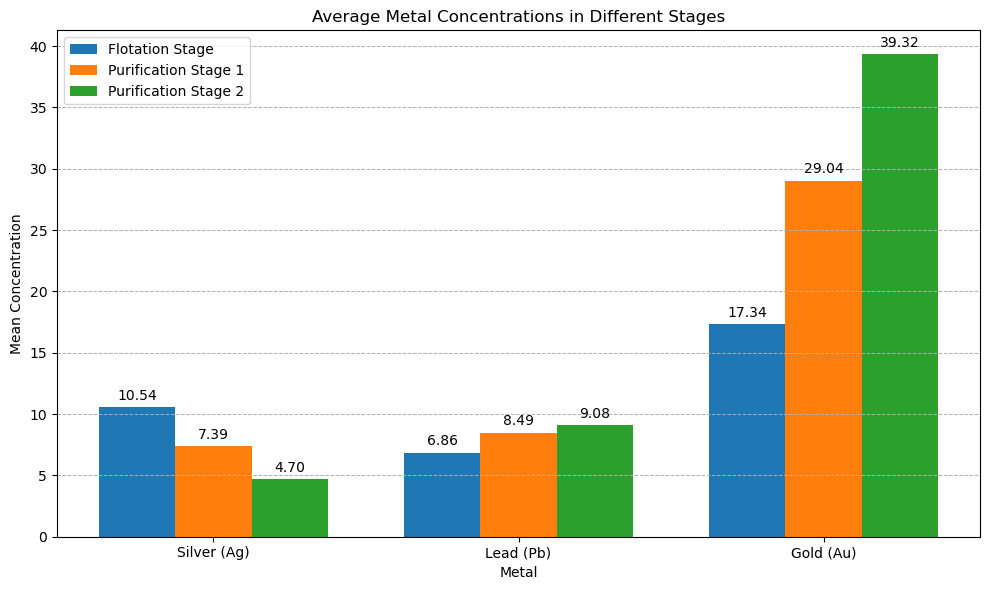

SILVER (Ag) CONCENTRATION % CHANGE:
-----------------------------------
Flotation Stage to Purification Stage 1: -29.89%
Purification Stage 1 to Purification Stage 2: -36.42%
Flotation Stage to Purification Stage 2: -55.42%

LEAD (Pb) CONCENTRATION % CHANGE:
---------------------------------
Flotation Stage to Purification Stage 1: 23.79%
Purification Stage 1 to Purification Stage 2: 6.91%
Flotation Stage to Purification Stage 2: 32.35%

GOLD (Au) CONCENTRATION % CHANGE:
---------------------------------
Flotation Stage to Purification Stage 1: 67.51%
Purification Stage 1 to Purification Stage 2: 35.40%
Flotation Stage to Purification Stage 2: 126.80%


In [18]:
# Calculating average concentrations of metals (Ag, Pb, Au) across different stages
avg_float_concentrations = train_data_complete[['rougher.output.concentrate_ag', 
                                                'rougher.output.concentrate_pb', 
                                                'rougher.output.concentrate_au']].mean()

avg_pure_1_concentrations = train_data_complete[['primary_cleaner.output.concentrate_ag', 
                                                'primary_cleaner.output.concentrate_pb', 
                                                'primary_cleaner.output.concentrate_au']].mean()

avg_pure_2_concentrations = train_data_complete[['final.output.concentrate_ag', 
                                                'final.output.concentrate_pb', 
                                                'final.output.concentrate_au']].mean()

# Setting up the bar plot to visualize the average concentrations across stages
bar_labels = ['Silver (Ag)', 'Lead (Pb)', 'Gold (Au)']
bar_width = 0.25
index = np.arange(len(bar_labels))
fig, ax = plt.subplots(figsize=(10, 6))

float_bar = ax.bar(index - bar_width, avg_float_concentrations, bar_width, label='Flotation Stage')
pure_1_bar = ax.bar(index, avg_pure_1_concentrations, bar_width, label='Purification Stage 1')
pure_2_bar = ax.bar(index + bar_width, avg_pure_2_concentrations, bar_width, label='Purification Stage 2')

# Plot labels and settings
ax.set_xlabel('Metal')
ax.set_ylabel('Mean Concentration')
ax.set_title('Average Metal Concentrations in Different Stages')
ax.set_xticks(index)
ax.set_xticklabels(bar_labels)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax.legend()

# Function to display values on top of bars
def display_value(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Calling the function to display values on bars
display_value(float_bar)
display_value(pure_1_bar)
display_value(pure_2_bar)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Percen Change function
def percent_change(initial_value, final_value):
    return ((final_value - initial_value) / initial_value) * 100

# Concentration Percent Change function
def concentration_percent_change(float_pure1, pure1_pure2, float_pure2):
    print(f"Flotation Stage to Purification Stage 1: {float_pure1:.2f}%")
    print(f"Purification Stage 1 to Purification Stage 2: {pure1_pure2:.2f}%")
    print(f"Flotation Stage to Purification Stage 2: {float_pure2:.2f}%")

# Printing percentage change in metal concentrations across stages
print("SILVER (Ag) CONCENTRATION % CHANGE:")
print("-----------------------------------")
concentration_percent_change(
    percent_change(avg_float_concentrations['rougher.output.concentrate_ag'], avg_pure_1_concentrations['primary_cleaner.output.concentrate_ag']), 
    percent_change(avg_pure_1_concentrations['primary_cleaner.output.concentrate_ag'], avg_pure_2_concentrations['final.output.concentrate_ag']), 
    percent_change(avg_float_concentrations['rougher.output.concentrate_ag'], avg_pure_2_concentrations['final.output.concentrate_ag']))
print()

print("LEAD (Pb) CONCENTRATION % CHANGE:")
print("---------------------------------")
concentration_percent_change(
    percent_change(avg_float_concentrations['rougher.output.concentrate_pb'], avg_pure_1_concentrations['primary_cleaner.output.concentrate_pb']), 
    percent_change(avg_pure_1_concentrations['primary_cleaner.output.concentrate_pb'], avg_pure_2_concentrations['final.output.concentrate_pb']), 
    percent_change(avg_float_concentrations['rougher.output.concentrate_pb'], avg_pure_2_concentrations['final.output.concentrate_pb']))
print()

print("GOLD (Au) CONCENTRATION % CHANGE:")
print("---------------------------------")
concentration_percent_change(
    percent_change(avg_float_concentrations['rougher.output.concentrate_au'], avg_pure_1_concentrations['primary_cleaner.output.concentrate_au']), 
    percent_change(avg_pure_1_concentrations['primary_cleaner.output.concentrate_au'], avg_pure_2_concentrations['final.output.concentrate_au']), 
    percent_change(avg_float_concentrations['rougher.output.concentrate_au'], avg_pure_2_concentrations['final.output.concentrate_au']))


The analysis of metal concentration changes across purification stages offers crucial insights into the dynamics of the gold recovery process. Examining the data reveals distinct patterns for silver, lead, and gold concentrations as they progress from the initial flotation stage through two purification stages. Silver demonstrates a consistent decrease across stages, with a significant reduction of 55.42% from flotation to the final purification, indicating robust removal efficiency. In contrast, lead shows an initial increase during flotation to the first purification stage, followed by a more modest rise thereafter, suggesting stabilization or incomplete removal. Gold exhibits the most striking trend, with substantial concentration increases at each stage, reflecting effective concentration and refining processes. These findings underscore the process's efficacy in selectively concentrating gold while managing the removal of other metals, providing critical insights for optimizing recovery efficiency and product quality in gold mining operations.

## 2.2. Compare the feed particle size distributions in the training set and in the test set

We will now compare the distributions of feed particle sizes between the training and test datasets. Particle size is a critical parameter in mineral processing as it directly affects the efficiency of processes like flotation and purification. By examining the statistics and visualizing these distributions, we aim to ensure that the model evaluation remains accurate and generalizable across different datasets. The code fetches basic statistics such as mean, standard deviation, and quartiles for rougher and primary cleaner feed sizes in both datasets. Additionally, it plots kernel density estimation (KDE) graphs to visually compare how particle size distributions vary between the training and test sets. KDE plots are employed here because they provide a smoothed representation of the probability density function of the data. This visualization method helps in understanding the shape and spread of particle size distributions in both datasets more intuitively than traditional histograms, allowing for a clearer comparison of the data's distributional characteristics. Identifying significant differences in these distributions helps in understanding potential biases or inconsistencies that could impact model performance and interpretation.

TRAINING DATA PRIMARY CLEANER FEED SIZE STATS:
----------------------------------------------
count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

TEST DATA PRIMARY CLEANER FEED SIZE STATS:
------------------------------------------
count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


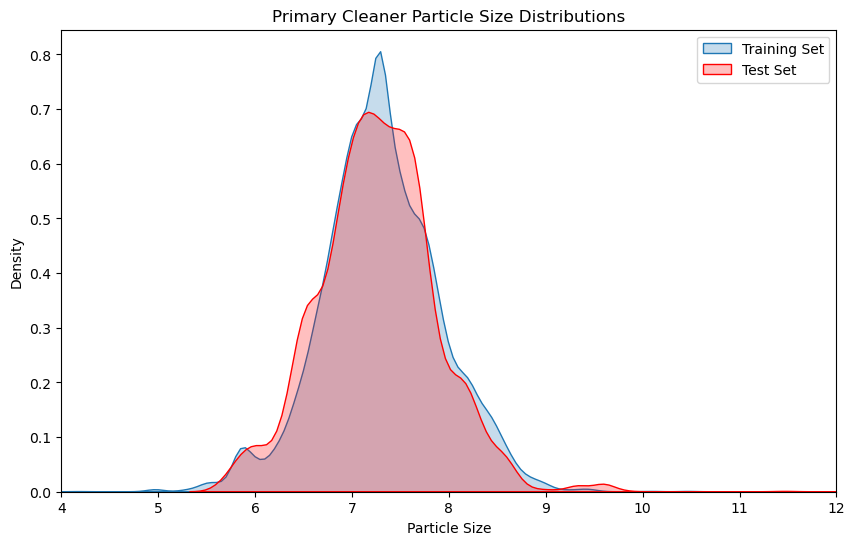

In [19]:
# Print basic statistics for primary cleaner feed size in training data
print("TRAINING DATA PRIMARY CLEANER FEED SIZE STATS:")
print("----------------------------------------------")
print(train_data_complete['primary_cleaner.input.feed_size'].describe())
print()

# Print basic statistics for primary cleaner feed size in test data
print("TEST DATA PRIMARY CLEANER FEED SIZE STATS:")
print("------------------------------------------")
print(test_data_complete['primary_cleaner.input.feed_size'].describe())

# Visualize the kernel density estimation (KDE) plot for primary cleaner feed size distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(train_data_complete['primary_cleaner.input.feed_size'], fill=True, label='Training Set')
sns.kdeplot(test_data_complete['primary_cleaner.input.feed_size'], fill=True, label='Test Set', color='red')
plt.xlabel('Particle Size')
plt.ylabel('Density')
plt.title('Primary Cleaner Particle Size Distributions')
plt.xlim(4, 12)
plt.legend()
plt.show()

The statistics for the primary cleaner feed size in both training and test datasets highlight a consistent mean of approximately 7.30 units in the training data and 7.26 units in the test data, with narrow standard deviations around 0.62 units and 0.61 units respectively. This indicates a tightly clustered distribution around the mean in both datasets, suggesting consistent operational conditions.

TRAINING DATA ROUGHER FEED SIZE STATS:
--------------------------------------
count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

TEST DATA ROUGHER FEED SIZE STATS:
----------------------------------
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


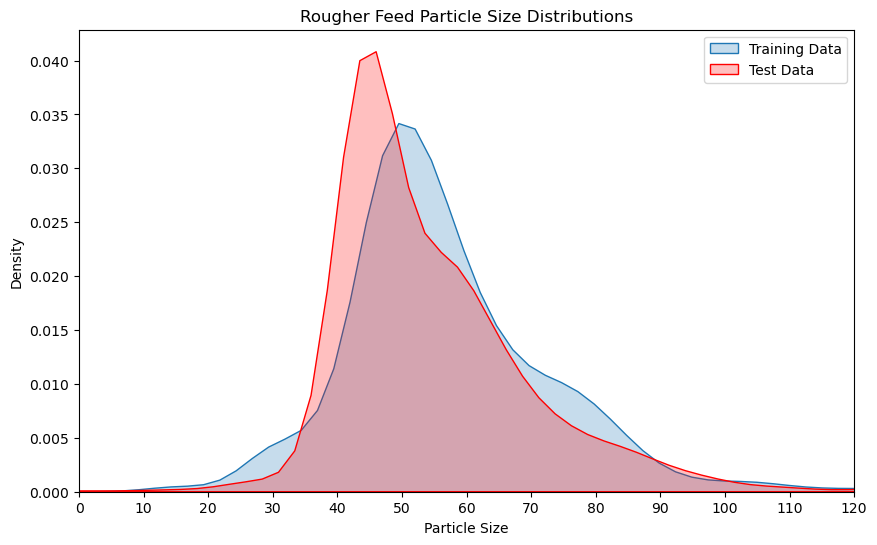

In [20]:
# Print basic statistics for rougher feed size in training data
print("TRAINING DATA ROUGHER FEED SIZE STATS:")
print("--------------------------------------")
print(train_data_complete['rougher.input.feed_size'].describe())
print()

# Print basic statistics for rougher feed size in test data
print("TEST DATA ROUGHER FEED SIZE STATS:")
print("----------------------------------")
print(test_data_complete['rougher.input.feed_size'].describe())

# Visualize the kernel density estimation (KDE) plot for rougher feed size distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(train_data_complete['rougher.input.feed_size'], fill=True, label='Training Data')
sns.kdeplot(test_data_complete['rougher.input.feed_size'], fill=True, label='Test Data', color='red')
plt.xlabel('Particle Size')
plt.ylabel('Density')
plt.title('Rougher Feed Particle Size Distributions')
plt.xlim(0, 120)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.legend()
plt.show()

The comparison between the rougher feed particle size distributions in the training and test datasets reveals that while their central tendencies (mean and median) are similar, the training dataset exhibits greater variability and includes unusually high maximum values. This variability could introduce biases if not addressed during model training and evaluation. To ensure robust model performance and generalizability, it may be necessary to apply min-max scaling techniques to the particle size data. This step would help mitigate the disparities in distribution ranges between the training and test datasets, ensuring that the model learns from a consistent scale of particle size inputs and can generalize effectively to new data.

In [21]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on training data and transform it
train_data_scaled = train_data_complete.copy()  # Make a copy of the dataframe
train_data_scaled['rougher.input.feed_size'] = scaler.fit_transform(train_data_scaled[['rougher.input.feed_size']])

# Transform the test data using the fitted scaler from training data
test_data_scaled = test_data_complete.copy()  # Make a copy of the dataframe
test_data_scaled['rougher.input.feed_size'] = scaler.transform(test_data_scaled[['rougher.input.feed_size']])

Now that we have successfully scaled the rougher feed size feature for both the training and test datasets, let's reexamine the statistics to determine if the distributions still exhibit significant differences.

TRAINING DATA ROUGHER FEED SIZE STATS (SCALED):
-----------------------------------------------
count    16860.000000
mean         0.106308
std          0.064216
min          0.000000
25%          0.079715
50%          0.093427
75%          0.117266
max          1.000000
Name: rougher.input.feed_size, dtype: float64

TEST DATA ROUGHER FEED SIZE STATS (SCALED):
-------------------------------------------
count    5856.000000
mean        0.097283
std         0.047775
min        -0.020225
25%         0.071939
50%         0.084798
75%         0.109336
max         0.984174
Name: rougher.input.feed_size, dtype: float64


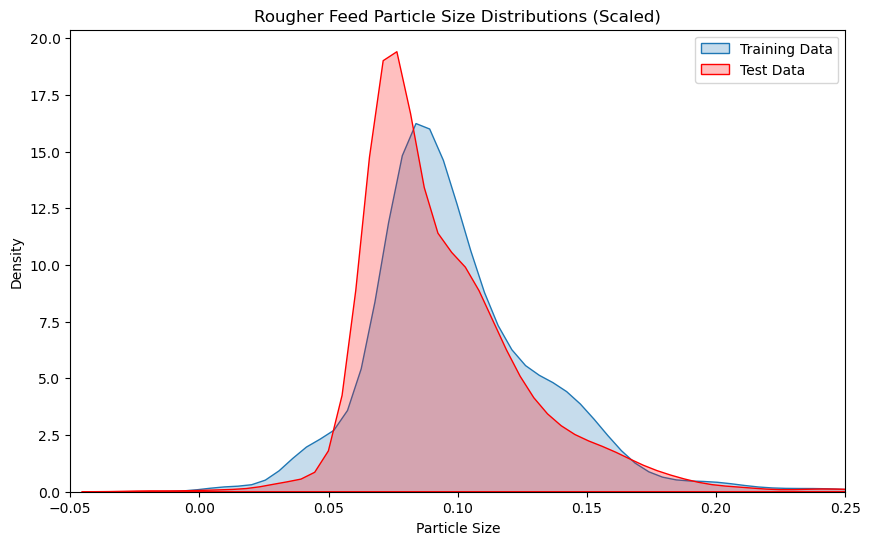

In [22]:
# Print basic statistics for rougher feed size in training data
print("TRAINING DATA ROUGHER FEED SIZE STATS (SCALED):")
print("-----------------------------------------------")
print(train_data_scaled['rougher.input.feed_size'].describe())
print()

# Print basic statistics for rougher feed size in test data
print("TEST DATA ROUGHER FEED SIZE STATS (SCALED):")
print("-------------------------------------------")
print(test_data_scaled['rougher.input.feed_size'].describe())

# Visualize the kernel density estimation (KDE) plot for rougher feed size distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(train_data_scaled['rougher.input.feed_size'], fill=True, label='Training Data')
sns.kdeplot(test_data_scaled['rougher.input.feed_size'], fill=True, label='Test Data', color='red')
plt.xlabel('Particle Size')
plt.ylabel('Density')
plt.title('Rougher Feed Particle Size Distributions (Scaled)')
plt.xlim(-0.05, 0.25)
plt.legend()
plt.show()

After applying min-max scaling to the **rougher.input.feed_size** feature in both the training and test datasets, we observe several key insights into the particle size distribution. In the training dataset, the scaled mean feed size is approximately 0.106, with a standard deviation of 0.064, indicating a tighter distribution around the mean compared to the unscaled data. The minimum feed size is now normalized to 0, and the maximum is scaled to 1, reflecting the entire range of values within a uniform scale. Similarly, in the test dataset, the mean scaled feed size is slightly lower at 0.097, with a standard deviation of 0.048. The minimum scaled value is slightly negative due to scaling adjustments, while the maximum is close to 0.984. These statistics suggest that min-max scaling has effectively transformed the original data into a consistent range between 0 and 1, maintaining the relative differences in particle sizes between datasets. This transformation is beneficial for machine learning models as it ensures that the feature values are comparable and interpretable across different datasets, facilitating more robust and accurate model training and evaluation.

## 2.3. Consider the total concentrations of all substances at different stages

In this part of the project, the goal is to analyze the total concentrations of substances at different stages of the gold recovery process—raw feed, rougher concentrate, and final concentrate. The code begins by defining a list of columns containing these concentrations. It then defines a function **remove_and_print_outliers** to identify and remove outliers using the interquartile range (IQR) method for each substance concentration column. After removing outliers from both the training and test datasets, the code calculates and prints statistics such as the number of outliers detected per substance, the percentage change in dataset size after outlier removal, and the percentage change in total concentrations for each stage after removing outliers. This process aims to identify any abnormal values that could affect model training and evaluates the impact of outlier removal on dataset integrity and statistical distributions.

In [23]:
# List of columns containing concentrations of substances at different stages
concentration_columns = ['rougher.input.feed_ag', 
                         'rougher.input.feed_pb',
                         'rougher.input.feed_au',

                         'rougher.output.concentrate_ag',
                         'rougher.output.concentrate_pb', 
                         'rougher.output.concentrate_au',
                                                                                 
                         'final.output.concentrate_ag',
                         'final.output.concentrate_pb', 
                         'final.output.concentrate_au']

print(f"TRAINING DATA SHAPE BEFORE REMOVING OUTLIERS: {train_data_scaled.shape}")
print()

# Remove and Print Outliers function
def remove_and_print_outliers(data, columns):
    outliers_df = pd.DataFrame(columns=['Substances', 'Outliers'])
    for col in columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outlier_count = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        outliers_df = pd.concat([outliers_df, pd.DataFrame({'Substances': [col], 'Outliers': [outlier_count]})], ignore_index=True)
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data, outliers_df

# Remove outliers from the training data and print statistics before and after
train_data_no_outliers, train_data_outliers = remove_and_print_outliers(train_data_scaled, concentration_columns)
print("TRAINING DATA SUBSTANCES OUTLIERS:")
print("-----------------------------------------")
print(train_data_outliers)
print("-----------------------------------------")
print()
print(f"TRAINING DATA SHAPE AFTER REMOVING OUTLIERS: {train_data_no_outliers.shape}")
print()

# Calculate the percentage change in dataset size after removing outliers
print(f"TRAINING DATA SIZE % CHANGE: {percent_change(train_data_scaled.shape[0], train_data_no_outliers.shape[0]):.2f}%")

TRAINING DATA SHAPE BEFORE REMOVING OUTLIERS: (16860, 87)

TRAINING DATA SUBSTANCES OUTLIERS:
-----------------------------------------
                      Substances Outliers
0          rougher.input.feed_ag     1670
1          rougher.input.feed_pb      110
2          rougher.input.feed_au      141
3  rougher.output.concentrate_ag      732
4  rougher.output.concentrate_pb      509
5  rougher.output.concentrate_au      256
6    final.output.concentrate_ag      573
7    final.output.concentrate_pb      178
8    final.output.concentrate_au      502
-----------------------------------------

TRAINING DATA SHAPE AFTER REMOVING OUTLIERS: (12189, 87)

TRAINING DATA SIZE % CHANGE: -27.70%


The analysis of total concentrations of substances in the training dataset at different stages—raw feed, rougher concentrate, and final concentrate—reveals significant reductions in outliers and corresponding changes in dataset size and concentration percentages after outlier removal. Initially, the training dataset contained 16,860 samples across 87 features. Upon removing outliers, primarily identified in substances such as rougher input feed of silver (Ag) with 1,670 outliers, the dataset was reduced to 12,189 samples, marking a substantial 27.70% decrease in size.

In [24]:
print("TRAINING DATA:")
print()

# Print percentage change in total concentrations of raw feed after outlier removal
print("----------------------------------------------------------")
print("TOTAL RAW CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:")
print("----------------------------------------------------------")
print(f"Silver (Ag): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[0]):.2f}%")        
print(f"Lead (Pb): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[1]):.2f}%")
print(f"Gold (Au): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[2]):.2f}%")
print()

# Calculate total outliers removed for raw feed concentrations and print percentage change
train_total_raw_outliers = train_data_outliers['Outliers'].iloc[0] + train_data_outliers['Outliers'].iloc[1] + train_data_outliers['Outliers'].iloc[2]
print(f"Total % Change of Raw Concentrates: {percent_change(len(train_data_scaled), len(train_data_scaled) - train_total_raw_outliers):.2f}%")
print()

# Print percentage change in total concentrations of rougher stage after outlier removal
print("--------------------------------------------------------------")
print("TOTAL ROUGHER CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:")
print("--------------------------------------------------------------")
print(f"Silver (Ag): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[3]):.2f}%")
print(f"Lead (Pb): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[4]):.2f}%")
print(f"Gold (Au): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[5]):.2f}%")
print()

# Calculate total outliers removed for rougher stage concentrations and print percentage change
train_total_rougher_outliers = train_data_outliers['Outliers'].iloc[3] + train_data_outliers['Outliers'].iloc[4] + train_data_outliers['Outliers'].iloc[5]
print(f"Total % Change of Rougher Concentrates: {percent_change(len(train_data_scaled), len(train_data_scaled) - train_total_rougher_outliers):.2f}%")
print()

# Print percentage change in total concentrations of final stage after outlier removal
print("------------------------------------------------------------")
print("TOTAL FINAL CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:")
print("------------------------------------------------------------")
print(f"Silver (Ag): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[6]):.2f}%")
print(f"Lead (Pb): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[7]):.2f}%")
print(f"Gold (Au): {percent_change(len(train_data_scaled), len(train_data_scaled) - train_data_outliers['Outliers'].iloc[8]):.2f}%")
print()

# Calculate total outliers removed for final stage concentrations and print percentage change
train_total_final_outliers = train_data_outliers['Outliers'].iloc[6] + train_data_outliers['Outliers'].iloc[7] + train_data_outliers['Outliers'].iloc[8]
print(f"Total % Change of Final Concentrates: {percent_change(len(train_data_scaled), len(train_data_scaled) - train_total_final_outliers):.2f}%")

TRAINING DATA:

----------------------------------------------------------
TOTAL RAW CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:
----------------------------------------------------------
Silver (Ag): -9.91%
Lead (Pb): -0.65%
Gold (Au): -0.84%

Total % Change of Raw Concentrates: -11.39%

--------------------------------------------------------------
TOTAL ROUGHER CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:
--------------------------------------------------------------
Silver (Ag): -4.34%
Lead (Pb): -3.02%
Gold (Au): -1.52%

Total % Change of Rougher Concentrates: -8.88%

------------------------------------------------------------
TOTAL FINAL CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:
------------------------------------------------------------
Silver (Ag): -3.40%
Lead (Pb): -1.06%
Gold (Au): -2.98%

Total % Change of Final Concentrates: -7.43%


Examining the percentage changes in raw concentrations post-outlier removal shows reductions across all substances: silver (Ag) decreased by 9.91%, lead (Pb) by 0.65%, and gold (Au) by 0.84%, contributing to an overall reduction of 11.39% in total raw concentrates. Similarly, rougher concentrates saw reductions in silver (Ag), lead (Pb), and gold (Au) concentrations by 4.34%, 3.02%, and 1.52%, respectively, resulting in an 8.88% decrease overall. Final concentrate concentrations also decreased after outlier removal, with silver (Ag) down by 3.40%, lead (Pb) by 1.06%, and gold (Au) by 2.98%, leading to a total reduction of 7.43%. These findings suggest that outlier removal has effectively streamlined the training dataset, minimizing extreme values that could skew statistical analysis or model training.

We will now shift our focus to the test dataset, bearing in mind that it lacks some features present in the training dataset, particularly focusing only on raw concentration features. Therefore, our analysis will solely concentrate on these specific variables.

In [25]:
# Repeat the process for test data
print(f"TEST DATA SHAPE BEFORE REMOVING OUTLIERS: {test_data_scaled.shape}")
print()

# Remove outliers from the test data and print statistics before and after
test_data_no_outliers, test_data_outliers = remove_and_print_outliers(test_data_scaled, concentration_columns[0:3])
print("TEST DATA SUBSTANCES OUTLIERS:")
print("-----------------------------------------")
print(test_data_outliers)
print("-----------------------------------------")
print()
print(f"TEST DATA SHAPE AFTER REMOVING OUTLIERS: {test_data_no_outliers.shape}")
print()
print(f"TEST DATA SIZE % CHANGE: {percent_change(test_data_scaled.shape[0], test_data_no_outliers.shape[0]):.2f}%")
print()

# Print percentage change in total concentrations of raw feed after outlier removal
print("----------------------------------------------------------")
print("TOTAL RAW CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:")
print("----------------------------------------------------------")
print(f"Silver (Ag): {percent_change(len(test_data_scaled), len(test_data_scaled) - test_data_outliers['Outliers'].iloc[0]):.2f}%")        
print(f"Lead (Pb): {percent_change(len(test_data_scaled), len(test_data_scaled) - test_data_outliers['Outliers'].iloc[1]):.2f}%")
print(f"Gold (Au): {percent_change(len(test_data_scaled), len(test_data_scaled) - test_data_outliers['Outliers'].iloc[2]):.2f}%")
print()

# Calculate total outliers removed for raw feed concentrations and print percentage change
test_total_raw_outliers = test_data_outliers['Outliers'].iloc[0] + test_data_outliers['Outliers'].iloc[1] + test_data_outliers['Outliers'].iloc[2]
print(f"Total % Change of Raw Concentrates: {percent_change(len(test_data_scaled), len(test_data_scaled) - test_total_raw_outliers):.2f}%")

TEST DATA SHAPE BEFORE REMOVING OUTLIERS: (5856, 53)

TEST DATA SUBSTANCES OUTLIERS:
-----------------------------------------
              Substances Outliers
0  rougher.input.feed_ag      397
1  rougher.input.feed_pb      184
2  rougher.input.feed_au       21
-----------------------------------------

TEST DATA SHAPE AFTER REMOVING OUTLIERS: (5254, 53)

TEST DATA SIZE % CHANGE: -10.28%

----------------------------------------------------------
TOTAL RAW CONCENTRATIONS % CHANGE AFTER DROPPING OUTLIERS:
----------------------------------------------------------
Silver (Ag): -6.78%
Lead (Pb): -3.14%
Gold (Au): -0.36%

Total % Change of Raw Concentrates: -10.28%


The analysis of the test dataset's total concentrations reveals a notable reduction in outlier counts and subsequent changes in the distribution of raw feed concentrations. Before outlier removal, the dataset contained significant outliers, particularly in silver, lead, and gold concentrations for the rougher input feed, which were effectively reduced after outlier removal. This process resulted in a decrease of 10.28% in the dataset size. Post-removal, the concentrations of silver, lead, and gold showed decreases of 6.78%, 3.14%, and 0.36%, respectively. These reductions suggest that the initial dataset contained anomalies that skewed the distribution of raw feed concentrations, potentially affecting downstream stages like rougher and final concentrate. Removing these outliers helps ensure that the test data aligns more closely with expected operational norms, enhancing the reliability of predictions and evaluations in the ore processing model.

## 3.1. Write a function to calculate the final sMAPE value

**SMAPE (Symmetric Mean Absolute Percentage Error)** is a metric used to evaluate the accuracy of forecasts or predictions. It measures the percentage error between predicted values and actual values, accounting for scale differences and ensuring that the error measurement is symmetric, meaning it treats overestimations and underestimations equally. In the context of gold recovery prediction, SMAPE compares the predicted recovery values with actual recovery values, providing a standardized measure of prediction accuracy.

**Final SMAPE** in gold recovery prediction refers to a composite metric that combines SMAPE scores from different stages of the recovery process. Typically, in gold recovery modeling, predictions are made for two main stages: rougher recovery (which predicts the initial stage of gold recovery) and final recovery (which predicts the final stage of gold recovery). Final SMAPE is computed using weighted averages of SMAPE scores from these stages, with weights reflecting the relative importance or accuracy requirements of each stage. For instance, if rougher recovery predictions are less critical than final recovery predictions, final SMAPE may assign higher weight to the latter.

We will use these two key metrics used in evaluating the accuracy and performance of predictive models in gold recovery processes, helping to quantify prediction errors and assess model effectiveness in delivering reliable recovery estimates.

In [26]:
# sMPAPE function
def smape(target, predictions):
    return np.mean(np.abs(target - predictions) / ((np.abs(target) + np.abs(predictions)) / 2)) * 100

# Final sMPAPE function
def final_smape(smape_score_rougher, smape_score_final):
    return 0.25 * smape_score_rougher + 0.75 * smape_score_final

## 3.2. Train different models

Finally, we will train and evaluate different machine learning models for predicting gold recovery at different stages of the process: rougher concentrate and final concentrate. Before defining the features and variables for model training, we will ensure alignment between the training and test datasets by removing any columns not present in the test dataset, including the **date** feature. This step is crucial for preparing the data appropriately and ensuring consistency across model training and evaluation processes. Three models are trained and evaluated using cross-validation: Linear Regression, Decision Tree Regression with varying depths, and Random Forest Regression with varying depths and estimators. For each model, sMAPE is used as the evaluation metric, measuring prediction accuracy between predicted and actual recovery values. The final sMAPE combines the scores from both stages of recovery to provide an overall assessment of model performance. The results will help determine which model performs best in predicting gold recovery, which is crucial for optimizing the ore processing operations.

In [27]:
# Extract features and targets from the preprocessed training data
features = train_data_no_outliers.drop(columns=list(missing_test_data_columns) + ['date'])
targets = train_data_no_outliers[['rougher.output.recovery', 'final.output.recovery']]

### Linear Regression Model

In [28]:
# Initialize Linear Regression model
model_lr = LinearRegression()
smape_score_rougher_lr = cross_val_score(model_lr, features, targets['rougher.output.recovery'], cv=5, scoring=make_scorer(smape)).mean()
smape_score_final_lr = cross_val_score(model_lr, features, targets['final.output.recovery'], cv=5, scoring=make_scorer(smape)).mean()
final_smape_score_lr = final_smape(smape_score_rougher_lr, smape_score_final_lr)

# Model Evaluation function
def model_eval(smape_score_rougher, smape_score_final, final_smape_score):
    print("Rougher concentrate recovery sMAPE:", smape_score_rougher)
    print("Final concentrate recovery sMAPE:", smape_score_final)
    print("Final sMAPE:", final_smape_score)

# Print Linear Regression model metrics
print("LINEAR REGRESSION MODEL METRICS:")
print("--------------------------------")
model_eval(smape_score_rougher_lr, smape_score_final_lr, final_smape_score_lr)

LINEAR REGRESSION MODEL METRICS:
--------------------------------
Rougher concentrate recovery sMAPE: 7.155851393623481
Final concentrate recovery sMAPE: 9.924707358441077
Final sMAPE: 9.232493367236678


### Decision Tree Model

In [29]:
# Initialize and evaluate Decision Tree models with different depths
best_depth_dt = 0
smape_best_score_rougher_dt = 0
smape_best_score_final_dt = 0
final_smape_best_score_dt = np.inf

for depth in range(1, 5):
    # Initialize Decision Tree model
    model_dt = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    smape_score_rougher_dt = cross_val_score(model_dt, features, targets['rougher.output.recovery'], cv=5, scoring=make_scorer(smape)).mean()
    smape_score_final_dt = cross_val_score(model_dt, features, targets['final.output.recovery'], cv=5, scoring=make_scorer(smape)).mean()
    final_smape_score_dt = final_smape(smape_score_rougher_dt, smape_score_final_dt)
    
    # Update best scores if current model has lower final SMAPE
    if final_smape_score_dt < final_smape_best_score_dt:
        smape_best_score_rougher_dt = smape_score_rougher_dt
        smape_best_score_final_dt = smape_score_final_dt
        final_smape_best_score_dt = final_smape_score_dt
        best_depth_dt = depth

# Print best Decision Tree model metrics
print("DECISION TREE MODEL METRICS:")
print("----------------------------")
print("Best max_depth:", best_depth_dt)
print()
model_eval(smape_score_rougher_dt, smape_score_final_dt, final_smape_score_dt)

DECISION TREE MODEL METRICS:
----------------------------
Best max_depth: 1

Rougher concentrate recovery sMAPE: 7.540118580753882
Final concentrate recovery sMAPE: 8.995011590283806
Final sMAPE: 8.631288337901324


### Random Forest Model

In [30]:
# Initialize and evaluate Random Forest models with different depths and estimators
best_depth_rf = 0
best_est_rf = 0
smape_best_score_rougher_rf = 0
smape_best_score_final_rf = 0
final_smape_best_score_rf = np.inf

for depth in range(1, 5):
    for est in range(1, 10):
        # Initialize Random Forest model
        model_rf = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)
        smape_score_rougher_rf = cross_val_score(model_rf, features, targets['rougher.output.recovery'], cv=5, scoring=make_scorer(smape)).mean()
        smape_score_final_rf = cross_val_score(model_rf, features, targets['final.output.recovery'], cv=5, scoring=make_scorer(smape)).mean()
        final_smape_score_rf = final_smape(smape_score_rougher_rf, smape_score_final_rf)
        
        # Update best scores if current model has lower final SMAPE
        if final_smape_score_rf < final_smape_best_score_rf:
            smape_best_score_rougher_rf = smape_score_rougher_rf
            smape_best_score_final_rf = smape_score_final_rf
            final_smape_best_score_rf = final_smape_score_rf
            best_depth_rf = depth
            best_est_rf = est

# Print best Random Forest model metrics
print("RANDOM FOREST MODEL METRICS:")
print("----------------------------")
print("Best max_depth:", best_depth_rf)
print("Best n_estimator:", best_est_rf)
print()
model_eval(smape_best_score_rougher_rf, smape_best_score_final_rf, final_smape_best_score_rf)

RANDOM FOREST MODEL METRICS:
----------------------------
Best max_depth: 4
Best n_estimator: 8

Rougher concentrate recovery sMAPE: 7.101648569733395
Final concentrate recovery sMAPE: 8.50203095330161
Final sMAPE: 8.151935357409556


Based on the final sMAPE scores obtained from the three models, the Random Forest model emerges as the top performer with the lowest final sMAPE of approximately 8.15%. Following closely is the Decision Tree model with a sMAPE of 8.63%, while the Linear Regression model trails with a sMAPE of 9.23%. These results clearly demonstrate that the Random Forest model outperforms both the Linear Regression and Decision Tree models in accurately predicting both rougher and final concentrate recoveries in the gold recovery process.

Now, we will employ the Random Forest model with the optimal hyperparameters to predict the rougher recovery and final recovery of gold.

### Final Random Forest Model

In [31]:
# Extracting features from the test dataset
features_test = test_data_no_outliers.drop(columns=['date'])

# Initializing the Random Forest model with best hyperparameters
final_model_rf = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=8)

# Training the Random Forest model on the training data
final_model_rf.fit(features, targets)

# Making predictions on the test dataset
predictions_test = final_model_rf.predict(features_test)

# Merging test data with full dataset to evaluate predictions
test_full_merged = test_data_no_outliers.merge(full_data_complete, on='date', how='left')
eval_df = test_full_merged[['date', 'rougher.output.recovery', 'final.output.recovery']].copy()

# Adding predicted values to the evaluation dataframe
eval_df.loc[:, 'rougher_recovery_predictions'] = predictions_test[:, 0]
eval_df.loc[:, 'final_recovery_predictions'] = predictions_test[:, 1] 

# Calculating sMAPE scores for rougher and final recovery predictions
smape_score_rougher = smape(eval_df['rougher.output.recovery'], eval_df['rougher_recovery_predictions'])
smape_score_final = smape(eval_df['final.output.recovery'], eval_df['final_recovery_predictions'])

# Calculating final sMAPE score
final_smape_score = final_smape(smape_score_rougher, smape_score_final)

# Printing final evaluation metrics
print("FINAL RANDOM FOREST MODEL METRICS:")
print("----------------------------------")
model_eval(smape_score_rougher, smape_score_final, final_smape_score)

# Displaying the evaluation dataframe
display(eval_df)

FINAL RANDOM FOREST MODEL METRICS:
----------------------------------
Rougher concentrate recovery sMAPE: 13.025738078504268
Final concentrate recovery sMAPE: 10.400385175447969
Final sMAPE: 11.056723401212043


,date,rougher.output.recovery,final.output.recovery,rougher_recovery_predictions,final_recovery_predictions
0,2016-09-01 00:59:59,89.993421,70.273583,86.613257,70.284552
1,2016-09-01 01:59:59,88.089657,68.910432,86.613257,70.284552
2,2016-09-01 02:59:59,88.412756,68.143213,86.613257,70.284552
3,2016-09-01 03:59:59,87.360133,67.776393,86.613257,70.284552
4,2016-09-01 04:59:59,83.236367,61.467078,85.864912,69.407528
...,...,...,...,...,...
5249,2017-12-31 19:59:59,95.172585,68.919891,31.433197,63.902273
5250,2017-12-31 20:59:59,94.575036,68.440582,32.739694,64.905163
5251,2017-12-31 21:59:59,93.018138,67.092759,91.058986,73.189656
5252,2017-12-31 22:59:59,92.599042,68.061186,91.058986,73.189656


## Conclusion

Based on the final evaluation metrics of the Random Forest model applied to predict rougher and final concentrate recoveries in the gold recovery process, we observed a sMAPE of approximately 13.03% for rougher concentrate recovery and 10.40% for final concentrate recovery. The combined final sMAPE score was calculated at 11.06%. These metrics indicate that while the model performs reasonably well in predicting final concentrate recovery with a lower error rate, there is an opportunity to improve predictions for the rougher stage to enhance overall process efficiency and yield in gold recovery operations.

Throughout the project, we employed various data preprocessing techniques including data cleaning, feature engineering, and outlier removal to prepare the dataset for modeling. We explored and compared three different regression models—Linear Regression, Decision Tree, and Random Forest—using cross-validation to evaluate their performance. Among these models, the Random Forest model consistently demonstrated superior performance based on the final sMAPE metric, showcasing its effectiveness in predicting both rougher and final concentrate recoveries.

In conclusion, the Random Forest model provides a solid baseline for predicting gold recovery metrics. Further refinements could potentially enhance its accuracy, particularly in addressing the challenges associated with rougher concentrate recovery predictions. Future work could focus on optimizing hyperparameters further, exploring alternative modeling techniques, and incorporating additional domain knowledge to improve overall predictive accuracy and reliability in gold recovery processes.